# Importing Packages

In [ ]:
!pip install aisdc

In [200]:
import os
import sys
import pylab as plt
import numpy as np
import logging
import importlib
import argparse
import json
import pickle
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score
from os.path import expanduser
from aisdc.safemodel.classifiers import SafeSVC
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.impute import KNNImputer
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow_privacy as tf_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from aisdc.safemodel.classifiers import SafeKerasModel
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow_privacy as tf_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from aisdc.attacks.attack_report_formatter import (  # pylint: disable=import-error
    GenerateTextReport,
)
from aisdc.attacks.likelihood_attack import LIRAAttack  # pylint: disable=import-error
from aisdc.attacks.target import Target  # pylint: disable=import-error
from aisdc.attacks.worst_case_attack import (  # pylint: disable=import-error
    WorstCaseAttack,
)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data preperation

## Loading train data

In [4]:
train_data = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/ADNI_train_volumes.tsv')
train_data = train_data.drop(columns=['Unnamed: 0', 'session_id', 'examination_date', 'earliest_time','rh.aparc.volume','lh.aparc.volume'])
train_data = train_data.drop(columns=['participant_id', 'Measure:volume'])
diagnosis_mapping = {'MCI': 2, 'CN': 0, 'AD': 1, 0.666667: 0}
train_data['diagnosis'] = train_data['diagnosis'].map(diagnosis_mapping)
train_data = train_data[(train_data['diagnosis'] == 0) | (train_data['diagnosis'] == 1)]

## Loading test data

In [5]:
test_data = pd.read_csv('C:/Users/alieyeh.moghaddam/Desktop/ADNI/ADNI_test_volumes.tsv')
test_data = test_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'session_id','participant_id','rh.aparc.volume','lh.aparc.volume'])
diagnosis_mapping = {'MCI': 2, 'CN': 0, 'AD': 1}
test_data['diagnosis'] = test_data['diagnosis'].map(diagnosis_mapping)
test_data = test_data[(test_data['diagnosis'] == 0) | (test_data['diagnosis'] == 1)]

## Cleaning data

In [6]:
# Making sure both train and test having same features
common_columns = set(train_data.columns).intersection(set(test_data.columns))
train_data = train_data[common_columns]
test_data = test_data[common_columns]

In [7]:
# Imputing missing values using KNN
imputer = KNNImputer(n_neighbors=3)
train_data = pd.DataFrame(imputer.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(imputer.fit_transform(test_data), columns=test_data.columns)

## Split data

In [8]:
X_train = train_data.drop(columns=['diagnosis'])
X_test = test_data.drop(columns=['diagnosis'])
y_train = train_data['diagnosis']
y_test = test_data['diagnosis']

## Normalising data

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Set Seed

In [10]:
SEED = 12345

# Baseline Models

## SVM Model

### SVM Hyperparameter Optimisation

In [11]:
svm = SVC()

param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale'],
    'probability': [True]
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='f1',verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END C=0.1, gamma=0.001, kernel=linear, probability=True; total time=   0.1s
[CV] END C=0.1, gamma=0.001, kernel=linear, probability=True; total time=   0.1s
[CV] END C=0.1, gamma=0.001, kernel=linear, probability=True; total time=   0.1s
[CV] END C=0.1, gamma=0.001, kernel=linear, probability=True; total time=   0.1s
[CV] END C=0.1, gamma=0.001, kernel=linear, probability=True; total time=   0.1s
[CV] END ..C=0.1, gamma=0.001, kernel=poly, probability=True; total time=   0.3s
[CV] END ..C=0.1, gamma=0.001, kernel=poly, probability=True; total time=   0.3s
[CV] END ..C=0.1, gamma=0.001, kernel=poly, probability=True; total time=   0.4s
[CV] END ..C=0.1, gamma=0.001, kernel=poly, probability=True; total time=   0.5s
[CV] END ..C=0.1, gamma=0.001, kernel=poly, probability=True; total time=   0.5s
[CV] END ...C=0.1, gamma=0.001, kernel=rbf, probability=True; total time=   0.5s
[CV] END ...C=0.1, gamma=0.001, kernel=rbf, pro

In [12]:
print(best_params)

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}


In [13]:
print(best_score)

0.8712065594899391


### Final SVM Model & Evaluation

In [15]:
clf = SVC(kernel='rbf', gamma='scale', C=10, probability=True)
clf.fit(X_train_scaled, y_train)
predictions = clf.predict(X_test_scaled)

In [16]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
f1 = f1_score(y_test, predictions)
print(f"F1-Score: {f1}")

Accuracy: 0.9301075268817204
F1-Score: 0.9326424870466321


In [17]:
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix

array([[83,  6],
       [ 7, 90]], dtype=int64)

### Save Model and Data

In [256]:
directory = "./SVM_unsafe"
print("Saving training/testing data to " + directory)
np.savetxt(os.path.join(directory, "x_train.txt"), X_train_scaled, fmt="%d")
np.savetxt(os.path.join(directory, "y_train.txt"), y_train, fmt="%d")
np.savetxt(os.path.join(directory, "x_test.txt"), X_test_scaled, fmt="%d")
np.savetxt(os.path.join(directory, "y_test.txt"), y_test, fmt="%d")

Saving training/testing data to ./1


In [257]:
filename = os.path.join(directory, "model.pkl")
print("Saving model to " + filename)
with open(filename, "wb") as file:
    pickle.dump(clf, file)

Saving model to ./1\model.pkl


### Attack

In [261]:
def generate_report(directory, target_model, x_train, y_train,
                                             x_test, y_test, 
                    attack_output_name, target_filename, outfile,):  # pylint: disable=too-many-arguments, disable=too-many-locals
    """Generate report based on target model."""

    print()
    print("Acting as TRE...")
    print()

    if not os.path.exists(directory):
        os.makedirs(directory)

    # Suppress messages from AI-SDC -- comment out these lines to
    # see all the aisdc logging statements
    logging.getLogger("attack-reps").setLevel(logging.WARNING)
    logging.getLogger("prep-attack-data").setLevel(logging.WARNING)
    logging.getLogger("attack-from-preds").setLevel(logging.WARNING)

    # Read the model to be released as supplied by the researcher
    model_filename = os.path.join(directory, target_model)
    print("Reading target model from " + model_filename)
    with open(model_filename, "rb") as file:
        target_model = pickle.load(file)

    # Read the training/testing data as supplied by the researcher
    print("Reading training/testing data from " + directory)
    train_x = np.loadtxt(os.path.join(directory, x_train))
    train_y = np.loadtxt(os.path.join(directory, y_train))
    test_x = np.loadtxt(os.path.join(directory, x_test))
    test_y = np.loadtxt(os.path.join(directory, y_test))

    # Wrap the training and test data into the Target object
    target = Target(model=target_model)
    target.add_processed_data(train_x, train_y, test_x, test_y)

    # Run the attack
    wca = WorstCaseAttack(
        n_dummy_reps=10, output_dir=directory, report_name=attack_output_name
    )
    wca.attack(target)

    _ = wca.make_report()

    # Define a configuration file for the attacks to be run
    lira_config = {
        "training_data_filename": "train_data.csv",
        "test_data_filename": "test_data.csv",
        "training_preds_filename": "train_preds.csv",
        "test_preds_filename": "test_preds.csv",
        "target_model": ["sklearn.svm"],
        "target_model_hyp": {"C": 10, "gamma": 'scale'},
    }

    with open(
        os.path.join(directory, "lira_config.json"), "w", encoding="utf-8"
    ) as file:
        file.write(json.dumps(lira_config))

    # Run the LIRA attack to test disclosure risk
    lira_attack_obj = LIRAAttack(
        n_shadow_models=100,
        attack_config_json_file_name=os.path.join(directory, "lira_config.json"),
        output_dir=directory,
        report_name=attack_output_name,
    )

    lira_attack_obj.attack(target)
    _ = lira_attack_obj.make_report()

    target.save(os.path.join(directory, "target"))

    text_report = GenerateTextReport()
    text_report.process_attack_target_json(
        os.path.join(directory, attack_output_name) + ".json",
        target_filename=os.path.join(directory, "target", target_filename),
    )

    text_report.export_to_file(
        output_filename=os.path.join(directory, outfile),
        move_files=True,
        model_filename=model_filename,
    )

    print("Results written to " + os.path.join(directory, outfile))

In [262]:
def run_user_story(release_config: dict):
    """Main method to parse arguments and then invoke report generation."""

    generate_report(
        release_config["training_artefacts_dir"],
        release_config["target_model"],
        release_config["x_train_path"],
        release_config["y_train_path"],
        release_config["x_test_path"],
        release_config["y_test_path"],
        release_config["attack_output_name"],
        release_config["target_results"],
        release_config["outfile"],
    )


Acting as TRE...

Reading target model from ./1\model.pkl
Reading training/testing data from ./1


INFO:_check_and_update_dataset:new ytrain has values and counts: (array([0, 1]), array([567, 527], dtype=int64))
INFO:_check_and_update_dataset:new ytest has values and counts: (array([0, 1]), array([89, 97], dtype=int64))
INFO:lr-scenario:Training shadow models
INFO:lr-scenario:Trained 0 models
INFO:lr-scenario:Trained 10 models
INFO:lr-scenario:Trained 20 models
INFO:lr-scenario:Trained 30 models
INFO:lr-scenario:Trained 40 models
INFO:lr-scenario:Trained 50 models
INFO:lr-scenario:Trained 60 models
INFO:lr-scenario:Trained 70 models
INFO:lr-scenario:Trained 80 models
INFO:lr-scenario:Trained 90 models
INFO:lr-scenario:Computing scores for train rows
INFO:lr-scenario:Computing scores for shadow rows
INFO:lr-scenario:Finished scenario
INFO:reporting:Starting reports, pdf report name = ./1\attack_output.pdf, json report name = ./1\attack_output.json
INFO:reporting:Wrote pdf report to ./1\attack_output.pdf and json report to ./1\attack_output.json


Results written to ./1\summary.txt


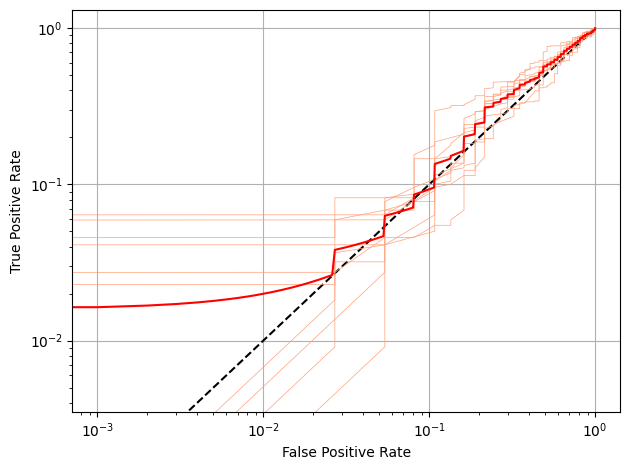

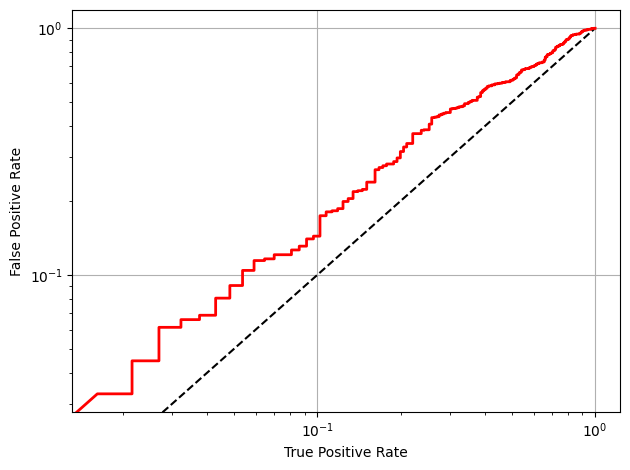

In [263]:
config = {
    'user_story': 3,
    'dataset_filename': 'C:/Users/alieyeh.moghaddam/Desktop/ADNI/ADNI_train_volumes.tsv',
    'target_model': "model.pkl",
    'outfile': "summary.txt",
    'attack_results': "attack_results.json",
    'training_artefacts_dir': "./SVM_unsafe",
    'target_results': "target.json",
    'x_train_path': "x_train.txt",
    'y_train_path': "y_train.txt",
    'x_test_path': "x_test.txt",
    'y_test_path': "y_test.txt",
    'attack_output_name': "attack_output"
}

run_user_story(config)

## Safe SVM Model

In [199]:
C = 10
# 1.6
# 4.1
gamma = 1.6
clf3 = SafeSVC(C=C, gamma=gamma)
clf3.fit(X_train_scaled, np.ravel(y_train,order="c"))
c3 = clf3.predict(X_test_scaled)
p3 = clf3.predict_proba(X_test_scaled)

In [198]:
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(y_test, c3)*100)
print("Precision:", metrics.precision_score(y_test, c3)*100)
print("Recall:", metrics.recall_score(y_test, c3)*100)
print("F1-score:", metrics.f1_score(y_test, c3)*100)

Accuracy: 46.236559139784944
Precision: 48.19277108433735
Recall: 41.23711340206185
F1-score: 44.44444444444444


In [252]:
directory = './SVM_safe'
filename = os.path.join(directory, "model2.pkl")
print("Saving model to " + filename)
with open(filename, "wb") as file:
    pickle.dump(clf3, file)

Saving model to ./2\model2.pkl


### Attack

In [253]:
def generate_report(
    # data_processing_filename,
    # data_processing_function_name,
    # dataset_filename,
    directory,
    target_model,
    attack_results,
    target_filename,
    outfile,
    X_train, X_test, y_train, y_test,
):  # pylint: disable=too-many-locals, disable=too-many-arguments
    """Generate report based on target model."""

    print()
    print("Acting as TRE...")
    print(
        "(when instructions on how to recreate the dataset have been provided by the researcher)"
    )
    print(directory)
    print()

    # Read in the model supplied by the researcher
    filename = os.path.join(directory, target_model)
    print("Reading target model from " + filename)
    with open(filename, "rb") as f:
        target_model = pickle.load(f)

    # x_train, x_test, Y_train, Y_test = process_dataset(X_train, X_test, y_train, y_test)

    # Wrap the model and data in a Target object
    target = Target(model=target_model)
    target.add_processed_data(X_train, y_train, X_test, y_test)

    # TRE calls request_release()
    print("===> now running attacks implicitly via request_release()")
    target_model.request_release(path=directory, ext="pkl", target=target)

    print(f"Please see the files generated in: {directory}")

    # Generate a report indicating calculated disclosure risk
    text_report = GenerateTextReport()
    text_report.process_attack_target_json(
        os.path.join(directory, attack_results),
        target_filename=os.path.join(directory, target_filename),
    )

    text_report.export_to_file(
        output_filename=os.path.join(directory, outfile), move_files=True
    )

    print("Results written to " + str(os.path.join(directory, outfile)))


In [254]:
def run_user_story(release_config: dict):
    """Main method to parse arguments and then invoke report generation."""

    generate_report(
        # release_config["data_processing_filename"],
        # release_config["data_processing_function_name"],
        # release_config["dataset_filename"],
        release_config["training_artefacts_dir"],
        release_config["target_model"],
        release_config["attack_results"],
        release_config["target_results"],
        release_config["outfile"],
        X_train_scaled, X_test_scaled, y_train, y_test,
    )



Acting as TRE...
(when instructions on how to recreate the dataset have been provided by the researcher)
./2

Reading target model from ./2\model2.pkl
===> now running attacks implicitly via request_release()


INFO:_check_and_update_dataset:new ytrain has values and counts: (array([0, 1]), array([567, 527], dtype=int64))
INFO:_check_and_update_dataset:new ytest has values and counts: (array([0, 1]), array([89, 97], dtype=int64))


attack worst_case, metadata {'experiment_details': {'n_reps': 10, 'reproduce_split': [5, 25, 36, 49, 64, 81, 100, 121, 144, 169], 'p_thresh': 0.05, 'n_dummy_reps': 1, 'train_beta': 1, 'test_beta': 1, 'test_prop': 0.5, 'n_rows_in': 1094, 'n_rows_out': 186, 'training_preds_filename': None, 'test_preds_filename': None, 'output_dir': './2', 'report_name': 'attack_results', 'include_model_correct_feature': False, 'sort_probs': True, 'mia_attack_model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'mia_attack_model_hyp': {'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 5}, 'attack_metric_success_name': 'P_HIGHER_AUC', 'attack_metric_success_thresh': 0.05, 'attack_metric_success_comp_type': 'lte', 'attack_metric_success_count_thresh': 5, 'attack_fail_fast': False, 'attack_config_json_file_name': None, 'target_path': None}, 'attack': 'WorstCase attack', 'global_metrics': {'null_auc_3sd_range': '0.4028 -> 0.5972', 'n_sig_auc_p_vals': 0, 'n_sig_auc_p_vals_corrected': 

INFO:lr-scenario:Training shadow models
INFO:lr-scenario:Trained 0 models
INFO:lr-scenario:Trained 10 models
INFO:lr-scenario:Trained 20 models
INFO:lr-scenario:Trained 30 models
INFO:lr-scenario:Trained 40 models
INFO:lr-scenario:Trained 50 models
INFO:lr-scenario:Trained 60 models
INFO:lr-scenario:Trained 70 models
INFO:lr-scenario:Trained 80 models
INFO:lr-scenario:Trained 90 models
INFO:lr-scenario:Computing scores for train rows
INFO:lr-scenario:Computing scores for shadow rows
INFO:lr-scenario:Finished scenario
INFO:reporting:Starting reports, pdf report name = ./2\attack_results.pdf, json report name = ./2\attack_results.json
INFO:reporting:Wrote pdf report to ./2\attack_results.pdf and json report to ./2\attack_results.json
INFO:aia:Starting reports, pdf report name = ./2\attack_results.pdf, json report name = ./2\attack_results.json


attack lira, metadata {'experiment_details': {'n_shadow_models': 100, 'p_thresh': 0.05, 'output_dir': './2', 'report_name': 'attack_results', 'training_data_filename': None, 'test_data_filename': None, 'training_preds_filename': None, 'test_preds_filename': None, 'target_model': None, 'target_model_hyp': None, 'attack_config_json_file_name': None, 'n_shadow_rows_confidences_min': 10, 'shadow_models_fail_fast': False, 'target_path': None}, 'global_metrics': {'PDIF_sig': 'Not significant at p=0.05', 'AUC_sig': 'Significant at p=0.05', 'null_auc_3sd_range': '0.4312868175323611 -> 0.5687131824676389'}, 'attack': 'LIRA Attack'}


INFO:aia:Wrote pdf report to ./2\attack_results.pdf and json report to ./2\attack_results.json


attack attribute, metadata {'experiment_details': {'output_dir': './2', 'report_name': 'attack_results', 'n_cpu': 11, 'attack_config_json_file_name': None, 'target_path': None}, 'attack': 'Attribute inference attack'}
Please see the files generated in: ./2
Results written to ./2\summary2.txt


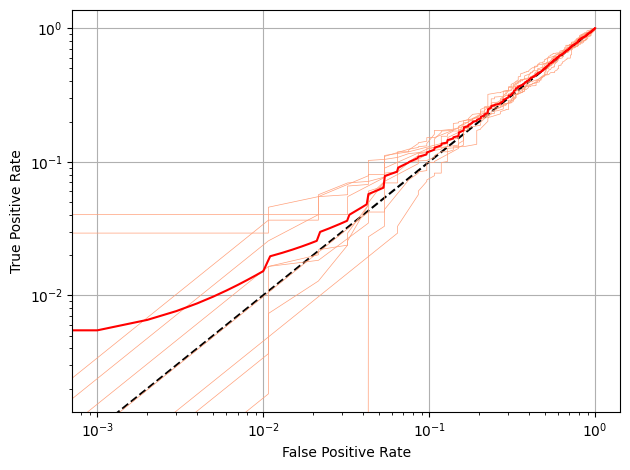

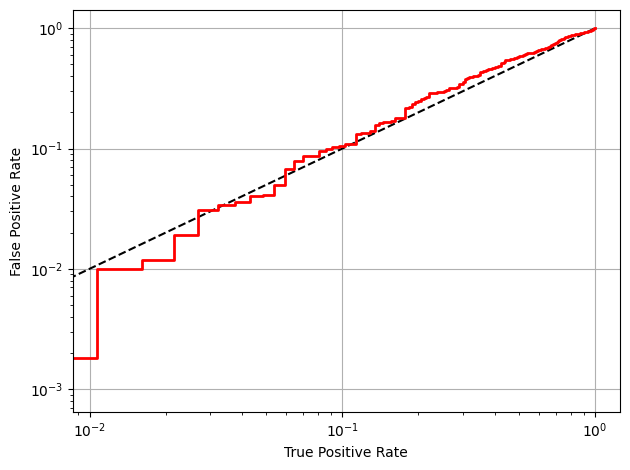

In [255]:
config = {
    'user_story': 2,
    'dataset_filename': 'C:/Users/alieyeh.moghaddam/Desktop/ADNI/ADNI_train_volumes.tsv',
    'target_model': "model2.pkl",
    'outfile': "summary.txt",
    'attack_results': "attack_results.json",
    'training_artefacts_dir': "./SVM_safe",
    'target_results': "target.json",
    'data_processing_filename': './data_processing_researcher.py',
    'data_processing_function_name': 'process_dataset'
}

run_user_story(config)